## One-dimensional hyperbolic systems

### Advection equation

First we are going to study the one-dimensional advection equation 
\begin{align}
     \frac{\partial }{\partial t} n= - a \frac{\partial}{\partial x} n 
 \end{align}
We are going to compare the first order upwind scheme with a centered differences scheme. Since forward in time centered in space is unconditionally unstable we add artificial diffusion to the latter.
 We discretize space with a cell-centered grid of $N_x$ points on the domain $[x_0,x_1]$. 
 
 In time we use the Bogacki-Shampine adaptive method of order 3 (adaption of order 2).
 
 We use Neumann boundary conditions and as initial condition we use the classical problem of a step function
 \begin{align}
    n(x,0) = \begin{cases} 1 \text{ for } x < x_a \\ 0 \text{ else}\end{cases}
 \end{align}
 
 As an alternative initial condition we can choose a wave function
 \begin{align}
     n(x,0) = n_0 + A \sin( k(x-x_0))
 \end{align}
    
We also remark that the advection equation has a simple analytical 
solution
\begin{align}
    n(x,t) = n(x-at, 0)
\end{align}

In order to run this notebook locally you will need
- a local instsallation of feltor: follow the quick-start guide https://github.com/feltor-dev/feltor (we do need jsoncpp and netcdf, but not glfw, and a link to path/to/feltor/inc/dg in home/include)
- a local installation of simplesimdb: follow the quick-start guide https://github.com/mwiesenberger/simplesimdb
- to compile the cpp codes in this repository: type make in a shell

In [1]:
import numpy as np
import simplesimdb as simplesim
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.animation as animation


In [2]:
# The code continuity.cpp discretizes the continuity equation
# in space and time with various schemes.
# In the following we document the possible input parameters:
def make_continuity_input() :
    return {
    "grid" : {
        "Nx" : 32, # number of grid points
        "x" : [0, 1], # spatial domain [x_0,x_1]
        "bc" : "NEU" # one of PER, NEU, DIR, DIR_NEU, NEU_DIR
    },
    "init": # initial condition
    {
        "type":"step", 
        "x_a" : 0.25 # location of step
#         "type" : "wave",
#         "n_0" 1.0,
#         "amp" : 1.0
#         "k"   : 1.0
#         "x_0" : 1.0
    },
    "advection" : { # numerical discretization
        "type" : "upwind",
        # upwind (classical 1st order upwind)
        # upwind2 (2nd order upwind formula)
        # centered (2nd order centered differences)
    },
    "timestepper":
    {
        # We implemented an adaptive embedded Runge Kutta method
        # (see the following link for a list)
        #https://feltor-dev.github.io/doc/dg/html/structdg_1_1_e_r_k_step.html
        "tableau" : "Bogacki-Shampine-4-2-3",
        "rtol" : 1e-5,
        "atol" : 1e-6
        
    },
    "physical":
    {
        "velocity" : 1.0, # a in Eq. 1
        "nu" : 0.0 
        # if non-zero a diffusion term is added to Eq. 1
    },
    "output":
    {
        # The simulation will run from t = 0 to t = t_end
        "tend" : 0.25, # end time
        # Choose a number of (equidistant in time) outputs
        # in output file (excluding first)
        "maxout" : 20 
    }
    }


In [3]:
# Let us run our first simulation and get an overview over
# the output file.

# We run simulations using the simplesimdb library
# In order for this to work you must first compile
# the code as described above, type:
# make continuity

# The simplesimdb library provides a simple python interface to the
# code via the Repeater class
# https://github.com/mwiesenberger/simplesimdb
rep = simplesim.Repeater("./continuity","temp.json", "temp.nc")
# in the following the temp.json and temp.nc files will be
# re-used for every simulation
rep.clean() # delete previously existing files
rep.run( make_continuity_input(), error="display", stdout="ignore")
# this will (i) write the input parameters to "temp.json"
# (ii) run the code, which
# (iii) produces the file "temp.nc"
ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
# Now with the help of pythons netcdf library we can pretty print
# an overview of output file
print( "FILE CONTENTS")
for v in ncin.variables:
    if v == "time" : 
        print(f"{v} {ncin.variables[v].shape}")
    else : 
        print( f"{v} {ncin.variables[v].shape}",
            f"\t{ ncin.variables[v].long_name}")
ncin.close()

FILE CONTENTS
time (21,)
x (32,) 	x-coordinate in Computational coordinate system
failed (21,) 	Number of failed steps
duration (21,) 	Computation time for the latest output (i.e. nsteps timesteps)
nsteps (21,) 	Number of calls to the timestepper (including failed steps)
numerical (21, 32) 	Numerical solution: Advected variable
analytical (21, 32) 	Analytical solution


In [4]:
# Here we define a simple plot routine
# It loops over all parameter sets that we give it, runs the
# corresponding simulation and then plots the analytical and
# numerical solutions at the last timestep
def plot_upwind( p_list):
    frows = 1
    fcols = 1
    plt.rcParams.update({'font.size': 16})
    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*10,frows*8),dpi= 80, facecolor='w', edgecolor='k')
    #https://matplotlib.org/stable/tutorials/colors/colormaps.html

    plotted = False
    for p in p_list :
        rep.clean()
        rep.run( p, error="display")
        ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
        x = ncin.variables["x"][:]
        analytic = ncin.variables["analytical"][:,:]
        last_idx = ncin.variables["time"].shape[0]-1
        numerical = ncin.variables["numerical"][:,:]
        if not plotted :
            im = ax.plot(x,analytic[last_idx,:], color='k',
                     label="analytical", lw=2)
            plotted = True
        l = f"{p['advection']['type']}"
        l = l + f" nu={p['physical']['nu']}"
        im = ax.plot(x,numerical[last_idx,:], label=l, lw=2)
        ncin.close()
    ax.set_title( f"Advection equation in 1D with Nx = {p['grid']['Nx']} points")
    ax.set_xlabel( r"s [$\rho_s$]")
    ax.set_ylabel("n")
    ax.legend()


As a first example we solve the continuity equation with the
step function initial condition with various schemes

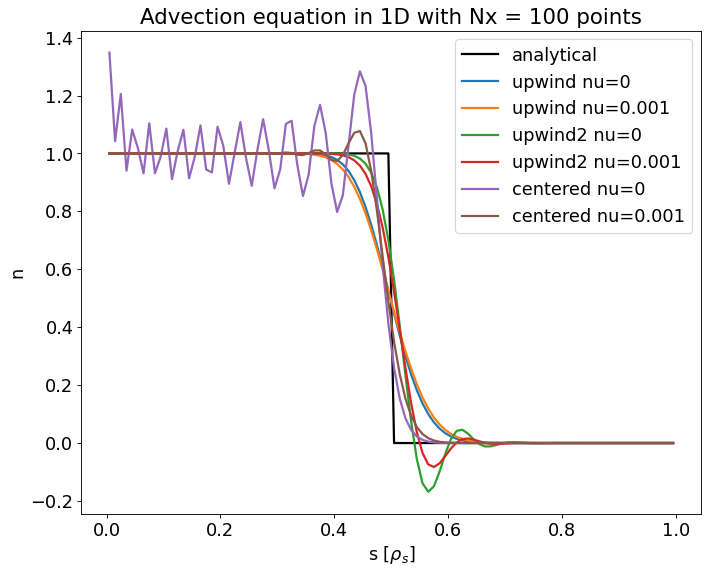

In [5]:
p_list = []
for p in ["upwind","upwind2", "centered"] :
    for nu in [0, 1e-3]:
        params = make_continuity_input()
        params["grid"]["Nx"] = 100
        params["advection"]["type"] = p
        params["physical"]["nu"] = nu
        p_list.append(params)
plot_upwind(p_list)

We find the expected results:
- the upwind scheme of first order does not produce oscillations and has inherent numerical diffusion
- the upwind scheme of 2nd order produces oscillations downstream
- the centered scheme without diffusion is unconditionally unstable and produces lots of oscillations
- only the first order upwind and the 2nd order schemes with diffusion produce smooth solutions
- adding the correct amount of numerical diffusion to the 2nd order schemes depends on the resolution

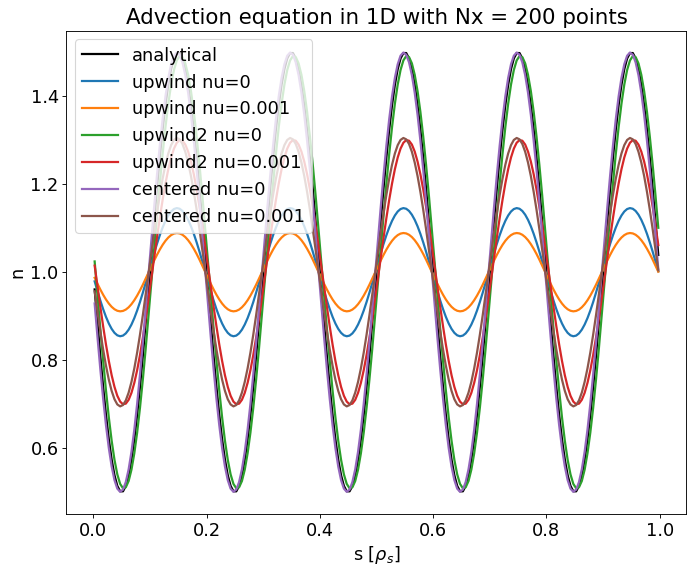

In [6]:
p_list = []
for p in ["upwind","upwind2", "centered"] :
    for nu in [0, 1e-3]:
        params = make_continuity_input()
        params["grid"]["Nx"] = 200
        params["grid"]["bc"] = "PER"
        params["output"]["tend"] = 0.5
        params["init"] = {"type" : "wave", "amp" : 0.5,
                          "n_0" : 1, "k" : 10*np.pi, "x_0" : 0}
        params["advection"]["type"] = p
        params["physical"]["nu"] = nu
        p_list.append(params)
plot_upwind(p_list)

In the wave example we can see that
- the upwind scheme of 1st order has a lot of numerical diffusion (even more than the artificial diffusion)
- the schemes with diffusion are stable but they do not converge to the correct solution
- the 2nd order schemes seem to be stable without diffusion (which is a wrong conclusion as we know that centered differences are unstable, we conclude that the sine wave is not a good test function to test stability)



### Navier stokes equation

We now turn to the one-dimensional compressional Navier-Stokes equation
 \begin{align}
     \frac{\partial }{\partial t} n&= - \frac{\partial}{\partial x} (un ) + \nu_n\frac{\partial^2}{\partial x^2} n \\
     \frac{\partial }{\partial t} nu&= - \frac{\partial}{\partial x} nu^2 - \alpha\frac{\partial}{\partial x} n^\gamma + \nu_u\frac{\partial^2}{\partial x^2} u
 \end{align}
 
 For $\gamma=1$ and $\alpha=\tau$ these are the equations for an ideal gas in 1d,
 while for $\gamma=2$ and $\alpha=0.5g$ we get the shallow water equations.
 
 A numerically particularly challenging initial condition is the Riemann problem
 \begin{align}
 n(x,0) = \begin{cases} n_l \text{ for } x < x_a \\
 n_r \text{ else}
 \end{cases} \\
 u(x,0) = \begin{cases} u_l \text{ for } x < x_a \\
u_r \text{ else}
\end{cases}
 \end{align}
 For $\gamma=1$ this leads to Sod's shock tube problem while for $\gamma=2$ and $u_l = u_r = 0$ we have 
 a dam break over a dry/wet bed. Both these cases are widely discussed in the literature and have
 analytical solutions {cite}`Delestre2013` for the shallow water case.
 
 We intend to study various schemes to discretize these equations. We will start with the usual naive finite difference approximations on a **collocated grid**, where both density and velocity are discretized on the same cell-centres.
 We either use centered
 differences for all derivatives or an upwind scheme for the advection term in the continuity equation and Burger's term (keeping centered differences for the
wave terms $-n\partial_x u$ and $-\alpha \partial_x n^\gamma$). These are the schemes that we used for our Feltor simulations in the past.
 
A more robust approach is to use a so-called **staggered grid** discretization. This is a finite-volume type scheme and the 
basic idea is to shift the velocity grid by half a grid-point
such that the density is given on cell-centres while the velocity
is given on the faces.
Of the staggered discretizations, a particularly robust one seems
to be the one presented in {cite}`Herbin2013` and the PhD thesis of {cite}`Gunawan2015` where favourable qualities are shown:
- it is **positivity preserving**
- it is shown to satisfy an **entropy inequality**
- it is **shock-capturing**

The defining features of the scheme is that the pressure term $\alpha\partial_x n^\gamma$ in the momentum equation is discretized
implicitly and that the momenum form is discretized instead of the velocity formulation. This makes the scheme **semi-implicit**, however the
implicit equation can be trivially solved since the density and momentum equations decouple.

We study various variations of the scheme including taking the pressure term explicitly and discretizing the velocity form.
\begin{align}
     \frac{\partial }{\partial t} u&= - \frac{\partial}{\partial x} \frac{u^2}{2} - \alpha n^{-1}\frac{\partial}{\partial x} n^\gamma + \nu_un^{-1}\frac{\partial^2}{\partial x^2} u
\end{align}
There
is also a 2nd order formulation using a **slope-limiter** proposed in {cite}`Gunawan2015`, which however might be closer to a flux-limter in fact.



In [7]:
# The code navier_stokes.cpp discretizes the above equations
# in space and time with various schemes.
# In the following we document the possible input parameters:
def make_navier_stokes_input() :
    return {
    "grid" : {
        "Nx" : 32, # number of grid points
        "x" : [0, 1], # spatial domain [x_0,x_1]
    },
#     "init":
#     {
#         # A sine wave in density and velocity
#         "type" : "wave",
#         "n_0" : 1,
#         "u_0" : 0.5,
#         "A" : 0.2,
#         "B" : 0.1,
#         "k" : 4*np.pi,
#         # Analytical solution only for gamma : 1
#     },
    "init":
    {
        "type" : "step", # same as riemann with 0 velocity
        "x_a" : 0.5, # location of jump
        "n_l" : 1,   # density left of jump
        "n_r" : 0.2, # density right of jump
        # Analytical solution only for gamma : 2
    },
#     "riemann":
#     {
#         "type" : "riemann",
#         "x_a" : 0.2, # location of jump
#         "n_l" : 1,   # density left of jump
#         "n_r" : 10, # density right of jump
#         "u_l" : 5,   # density left of jump
#         "u_r" : 7.5, # density right of jump
#     },
#     "init":
#     {
#          # Manufactured solution without shock
#         "type" : "mms",
#         "n_0" : 1,
#         "u_0" : 0.5,
#         "A" : 0.2,
#         "B" : 0.1,
#         "k" : 4*np.pi,
#         "v" : 1 # velocity of mms solution
#         # Analytical solution only for gamma : 1
#     },
    "advection" : 
    {
        "type" : "staggered", 
        # upwind
        # upwind2
        # centered
        # staggered (allows variant)
        # velocity-staggered (allows variant)
        "variant" : "original"
        # original (The original scheme, 1st order)
        # explicit (Take pressure term explicitly)
        # slope-limiter (Use 2nd order flux)
        # slope-limiter-explicit (Use 2nd order flux
        #     and pressure term explicit)
    },
    "timestepper":
    {
        # The Additive Runge Kutta (ARK) method is a semi-implicit
        # embedded Runge Kutta scheme that works for all (explicit
        # and implicit) advection schemes above
        "type" : "ARK",
        "tableau" : "ARK-4-2-3",
        "rtol" : 1e-6, # relative tolerance
        "atol" : 1e-7  # absolute tolerance
        # The Embedded Runge Kutta (ERK) only works 
        # for explicit schemes
        # "type" : "ERK", 
        # "tableau" : "Bogacki-Shampine-4-2-3"
    },
    "physical":
    {
        "nu_u" : 0.0, # viscosity
        "nu_n" : 0.0, # diffusivity (can be used to stabilize)
#         "gamma" : 1,
#         "alpha" : 1 
        # Shallow water equations:
        "gamma" : 2, 
        "alpha" : 9.81/2.0  # half the gravity
    },
    "bc" :
    {
         # one of PER, NEU, DIR, DIR_NEU, NEU_DIR
        "density": "NEU",
        "velocity" : "NEU"
    },
    "output":
    {
        # The simulation will run from t = 0 to t = t_end
        "tend" : 0.025, # end time
        # Choose a number of (equidistant in time) outputs
        # in output file (excluding first)
        "maxout" : 20 
    }
    }

In [8]:
# This works completely analogous to the continuity case above
rep = simplesim.Repeater("./navier_stokes","temp.json", "temp.nc")
rep.clean()
rep.run( make_navier_stokes_input(), error="display", stdout="ignore")
ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
print( "FILE CONTENTS")
for v in ncin.variables:
    if v == "time" : 
        print(f"{v} {ncin.variables[v].shape}")
    else : 
        print( f"{v} {ncin.variables[v].shape}",
            f"\t{ ncin.variables[v].long_name}")

ncin.close()

FILE CONTENTS
time (21,)
x (32,) 	x-coordinate in Computational coordinate system
failed (21,) 	Accumulated Number of failed steps
duration (21,) 	Computation time for the latest output
nsteps (21,) 	Accumulated Number of calls to the timestepper (including failed steps)
density (21, 32) 	Numerical density
velocity (21, 32) 	Numerical velocity
density_ana (21, 32) 	Analytical solution to the density
velocity_ana (21, 32) 	Analytical solution to the velocity


In [9]:
# Again, we define a plotting routine that loops over
# parameters sets, runs simulations and plots the results
def plot_navier_stokes( p_list):
    frows = 2
    fcols = 2
    plt.rcParams.update({'font.size': 18})

    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*10,frows*8),dpi= 80, facecolor='w', edgecolor='k')
    #https://matplotlib.org/stable/tutorials/colors/colormaps.html

    plotted = False
    for p in p_list :
        rep.clean()
        rep.run( p, error="display", stdout="ignore")
        ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
        var = ncin.variables
        last_idx  = var["time"].shape[0]-1
        nsteps = var["nsteps"][last_idx]
        nfailed = var["failed"][last_idx]
        error_n = var["density"][:,:] - var["density_ana"][:,:]
        norm_ana_n = np.linalg.norm( var["density_ana"][last_idx,:], ord=1)
        error_u = var["velocity"][:,:] - var["velocity_ana"][:,:]
        norm_ana_u = np.linalg.norm( var["velocity_ana"][last_idx,:], ord=1)
        #norm_ana = np.size( error[last_idx,:])


        # Compute entropy
        entropy = 0.5 * var["density"][:,:]*var["velocity"][:,:]**2
        if( p["physical"]["gamma"] == 1) :
            entropy = entropy + p["physical"]["alpha"] *var["density"][:,:]*np.log( var["density"][:,:])
        else :
            entropy = entropy + p["physical"]["alpha"]/(p["physical"]["gamma"]-1
                                                       ) *var["density"][:,:]**p["physical"]["gamma"]
        x = var["x"][:]

        if not plotted and (norm_ana_n != 0 or norm_ana_u != 0):
            im = ax[0][0].plot(x, var["density_ana"][last_idx,:],
                            color='k', label="analytical", lw=4)
            im = ax[0][1].plot(x, var["velocity_ana"][last_idx,:],
                            color='k', label="analytical", lw=4)
            plotted = True
        l = f"{p['advection']['type']}"
        if( "variant" in p["advection"].keys() ):
            l = l + f" {p['advection']['variant']}"
        print(l)
        if norm_ana_n != 0 or norm_ana_u != 0:
            print( f"\tL2 Error norm is {np.linalg.norm(error_n[last_idx,:],ord=1)/norm_ana_n:.2e}\
  {np.linalg.norm(error_u[last_idx,:], ord=1)/norm_ana_u:.2e}", end=" ")            
        print( f"\tFunction calls: {nsteps} Failed: {nfailed}")
        im = ax[0][0].plot(x,var["density"][last_idx,:], p["ls"], label=l, lw=4)
        im = ax[0][1].plot(x,var["velocity"][last_idx,:], p["ls"], label=l, lw=4,)
        im = ax[1][0].plot( var["time"][:], np.trapz( entropy[:,:], x, axis = 1), p["ls"], label=l, lw=4)
        ncin.close()
    ax[0][0].set_title( f"density Nx = {p['grid']['Nx']}")
    ax[0][0].set_xlabel( r"s [$\rho_s$]")
    ax[0][0].set_ylabel("n")
#     ax[0][0].legend()
    ax[0][1].set_title( f"velocity")
    ax[0][1].set_xlabel( r"s [$\rho_s$]")
    ax[0][1].set_ylabel("u")
    ax[1][0].set_title( f"Global entropy conservation")
    ax[1][0].set_xlabel( "t")
    ax[1][0].set_ylabel( r"$\eta$")
    ax[1][0].legend()
#     ax[1][1].legend()
    

As a first example we study the dam break over a dry bed without viscosity

staggered original
	L2 Error norm is 3.43e-03  1.19e-02 	Function calls: 4798.0 Failed: 0.0
staggered slope-limiter
	L2 Error norm is 9.80e-04  4.96e-03 	Function calls: 5800.0 Failed: 10.0


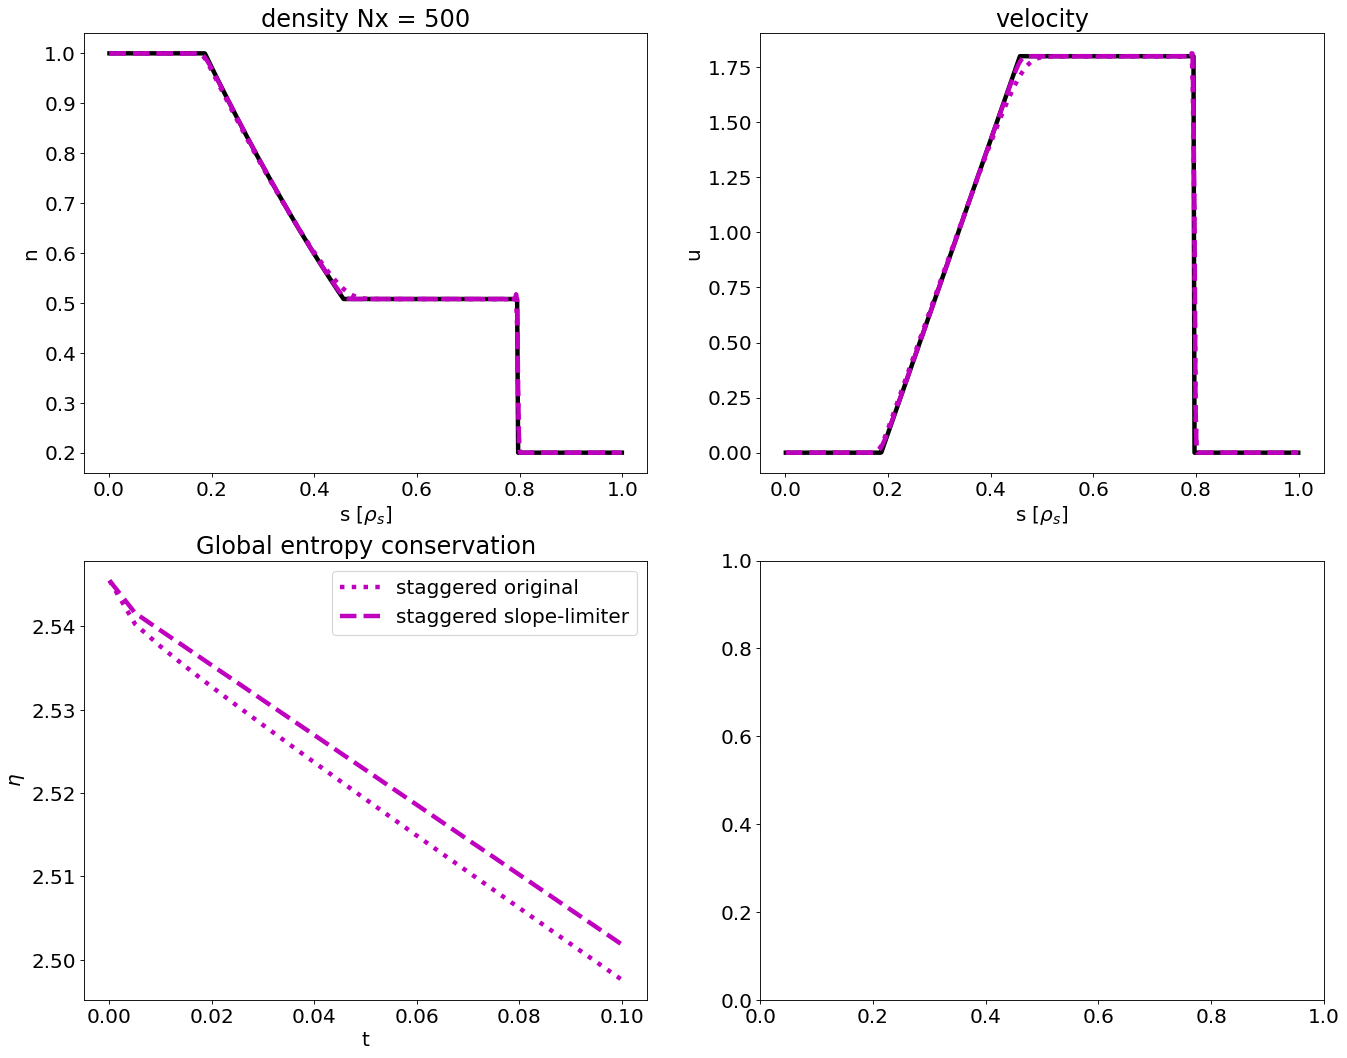

In [10]:
p_list = []
for p in [
#     {"type" : "velocity-staggered", "variant" : "original", "ls" : "b--"},
    {"type" : "staggered", "variant" : "original", "ls" : "m:"},
    {"type" : "staggered", "variant" : "slope-limiter", "ls" : "m--"},
        ] :
    params = make_navier_stokes_input()
    params["grid"]["Nx"]= 500
    params["ls"]= p["ls"]
    params["output"]["tend"] = 0.1
#     params["physical"]["nu_u"] = 0.01
    #params["physical"]["gamma"] = 1
    #params["physical"]["alpha"] = 1
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
#     params["timestepper"]["type"] = "ERK"
#     params["timestepper"]["tableau"]  = "Bogacki-Shampine-4-2-3"
    params["advection"] = p
    p_list.append(params)
plot_navier_stokes(p_list)

- the original schemes of 1st and 2nd order converge to the correct solution as advertised

Next, we try to solve Burger's equation

velocity-staggered explicit
	L2 Error norm is inf  9.69e-04 	Function calls: 1734.0 Failed: 0.0


<ipython-input-9-dd14ed1347aa>:47: RuntimeWarning: divide by zero encountered in double_scalars
  print( f"\tL2 Error norm is {np.linalg.norm(error_n[last_idx,:],ord=1)/norm_ana_n:.2e}\


velocity-staggered slope-limiter-explicit
	L2 Error norm is inf  8.15e-04 	Function calls: 2484.0 Failed: 38.0


<ipython-input-9-dd14ed1347aa>:47: RuntimeWarning: divide by zero encountered in double_scalars
  print( f"\tL2 Error norm is {np.linalg.norm(error_n[last_idx,:],ord=1)/norm_ana_n:.2e}\


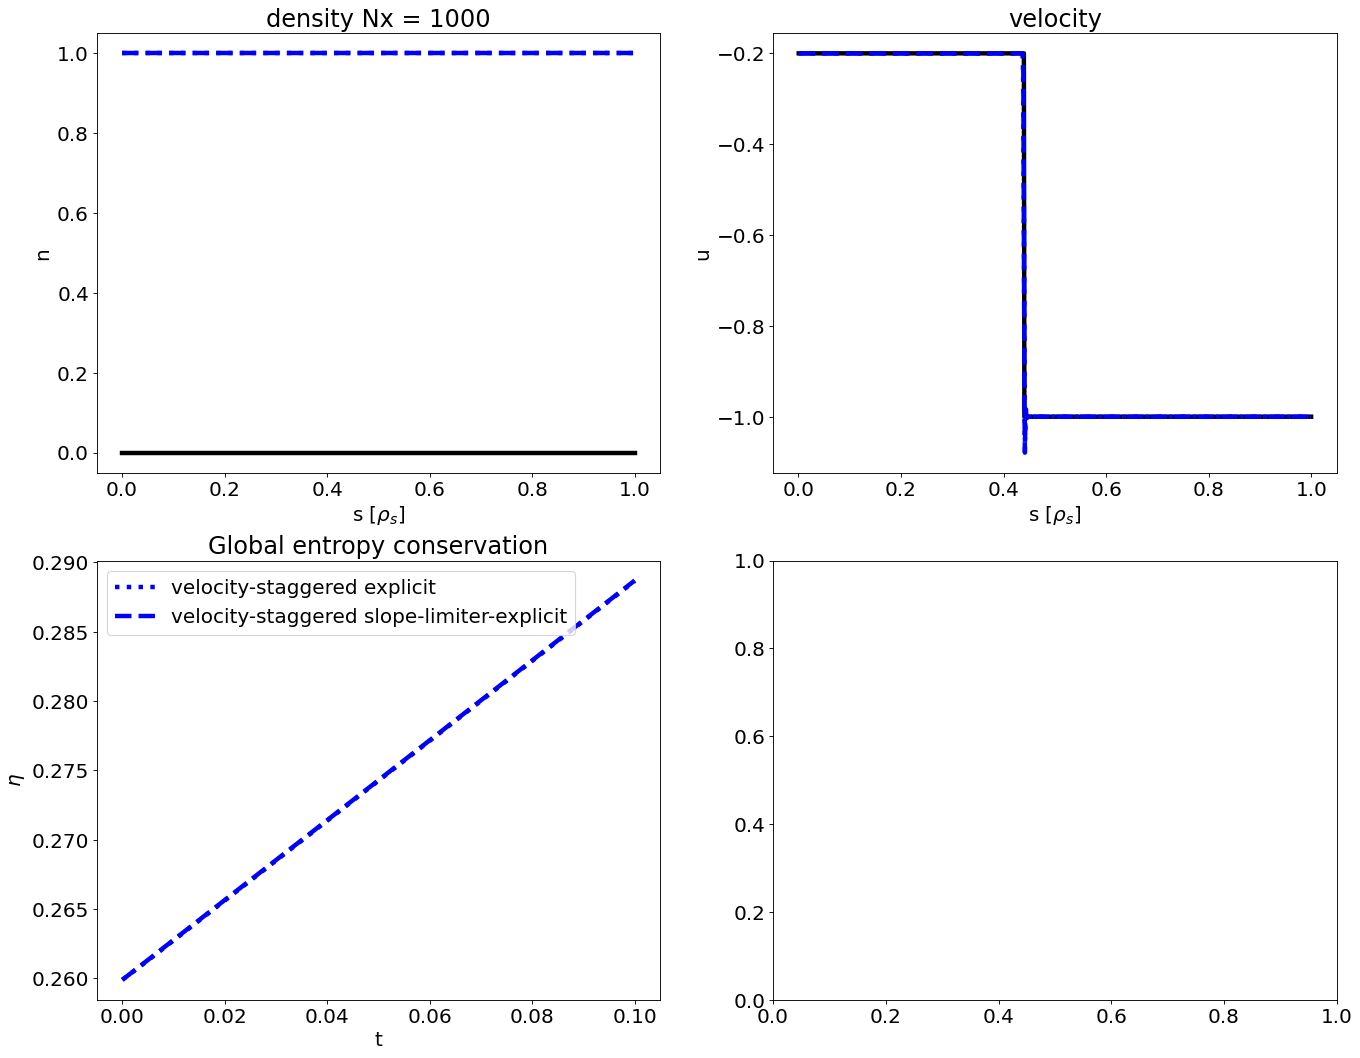

In [11]:
p_list = []
for p in [
#     {"type" : "staggered", "variant" : "original", "ls" : "g:"},
#     {"type" : "staggered", "variant" : "slope-limiter", "ls" : "g--"},
    {"type" : "velocity-staggered", "variant" : "explicit", "ls" : "b:"},
    {"type" : "velocity-staggered", "variant" : "slope-limiter-explicit", "ls" : "b--"},
#     {"type" : "velocity-staggered", "variant" : "slope-limiter", "ls" : "b--"},
#     {"type" : "upwind", "ls" : "r--"},
         ] :
    params = make_navier_stokes_input()
    params["grid"]["Nx"]= 1000
    params["output"]["tend"] = 0.1
    params["ls"] = p["ls"]
    params["init"] ={
        "type" : "riemann",
        "x_a" : 0.5, # location of jump
        "n_l" : 1,   # density left of jump
        "n_r" : 1,  # density right of jump
        "u_l" : -0.2,   # density left of jump
        "u_r" : -1, # density right of jump
    }
    params["physical"]["alpha"] = 0
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
    params["advection"] = p
    p_list.append(params)
plot_navier_stokes(p_list)

staggered original
	L2 Error norm is 7.08e-03  2.55e-02 	Function calls: 2314.0 Failed: 0.0
staggered slope-limiter
	L2 Error norm is 2.39e-03  1.21e-02 	Function calls: 2837.0 Failed: 7.0
staggered explicit
	L2 Error norm is 7.08e-03  2.55e-02 	Function calls: 2771.0 Failed: 0.0
staggered slope-limiter-explicit
	L2 Error norm is 2.39e-03  1.21e-02 	Function calls: 3691.0 Failed: 95.0
velocity-staggered original
	L2 Error norm is 1.89e-02  5.95e-02 	Function calls: 3502.0 Failed: 0.0
velocity-staggered explicit
	L2 Error norm is 1.89e-02  5.95e-02 	Function calls: 3539.0 Failed: 0.0
velocity-staggered slope-limiter-explicit
	L2 Error norm is 1.30e-02  4.39e-02 	Function calls: 4212.0 Failed: 55.0
velocity-staggered slope-limiter
	L2 Error norm is 1.30e-02  4.39e-02 	Function calls: 3834.0 Failed: 0.0
log-staggered explicit
	L2 Error norm is 3.32e-02  1.24e-01 	Function calls: 3353.0 Failed: 0.0
log-staggered slope-limiter
	L2 Error norm is 2.81e-02  1.03e-01 	Function calls: 4063.0 Fai

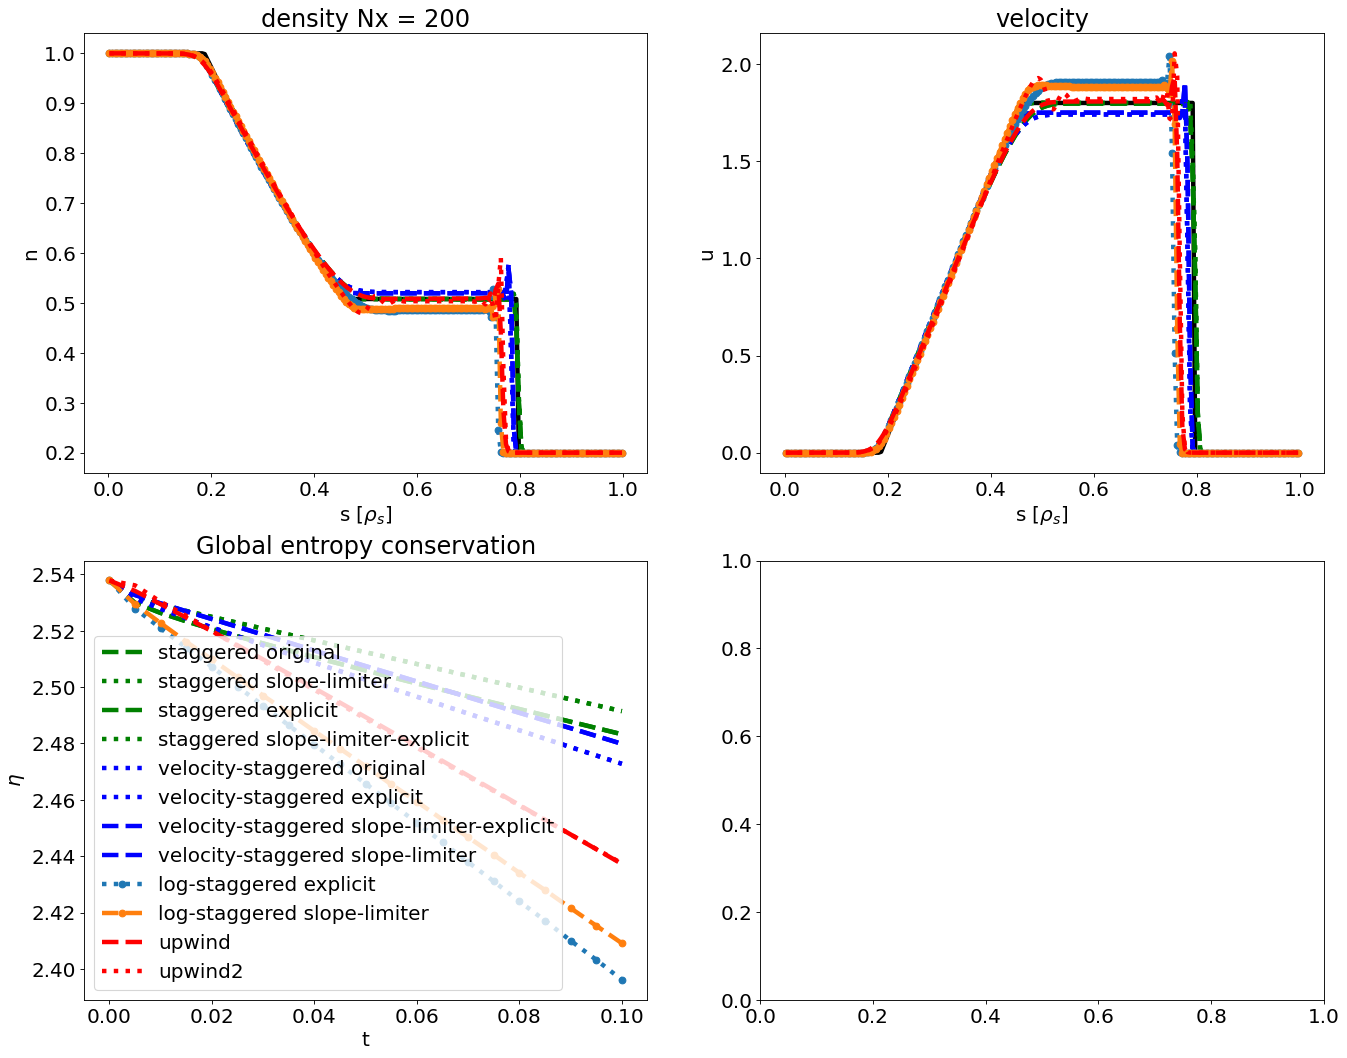

In [33]:
p_list = []
for p in [
    {"type" : "staggered", "variant" : "original", "ls" : "g--"},
    {"type" : "staggered", "variant" : "slope-limiter", "ls" : "g:"},
    {"type" : "staggered", "variant" : "explicit", "ls" : "g--"},
    {"type" : "staggered", "variant" : "slope-limiter-explicit", "ls" : "g:"},
    {"type" : "velocity-staggered", "variant" : "original", "ls" : "b:"},
    {"type" : "velocity-staggered", "variant" : "explicit", "ls" : "b:"},
    {"type" : "velocity-staggered", "variant" : "slope-limiter-explicit", "ls" : "b--"},
    {"type" : "velocity-staggered", "variant" : "slope-limiter", "ls" : "b--"},
#     {"type" : "centered", "ls" : "m--"},    
#     {"type" : "staggered-direct", "ls" : "y--"},
    {"type" : "log-staggered", "ls" : "o:", "variant": "explicit"},
    {"type" : "log-staggered", "ls" : "o--", "variant": "slope-limiter"},
    {"type" : "upwind", "ls" : "r--"},
    {"type" : "upwind2", "ls" : "r:"},
         ] :
    params = make_navier_stokes_input()
    params["grid"]["Nx"]= 200
    params["output"]["tend"] = 0.1
    params["ls"] = p["ls"]
#     params["physical"]["nu_u"] = 1e-4
#     params["physical"]["gamma"] = 1
#     params["physical"]["alpha"] = 1
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
    if( p["type"] == "upwind" or p["type"] == "upwind2" 
       or p["type"] == "centered" or p["type"] == "staggered-direct"
       or p["type"] == "log-staggered"):
        params["timestepper"]["type"] = "ERK"
        params["timestepper"]["tableau"]  = "Bogacki-Shampine-4-2-3"
    elif( p["variant"] == "explicit" or p["variant"] == "slope-limiter-explicit") :
        params["timestepper"]["type"] = "ERK"
        params["timestepper"]["tableau"]  = "Bogacki-Shampine-4-2-3"
    params["advection"] = p
    p_list.append(params)
plot_navier_stokes(p_list)

We see that even with very high resolution
- the explicit staggered schemes converge to the correct solution as well contradicting the literature; we are unable to reproduce Figure 1.6 in Gunawan's thesis (even after trying to use fixed-step Euler scheme in order to exclude effects from the different timestepper we use)
- the upwind and velocity-staggered schemes both do not converge to the analytic solution

staggered original
	Function calls: 746.0 Failed: 0.0
staggered slope-limiter
	Function calls: 1135.0 Failed: 13.0
staggered explicit
	Function calls: 810.0 Failed: 0.0
upwind
	Function calls: 662.0 Failed: 0.0
velocity-staggered slope-limiter
	Function calls: 946.0 Failed: 12.0


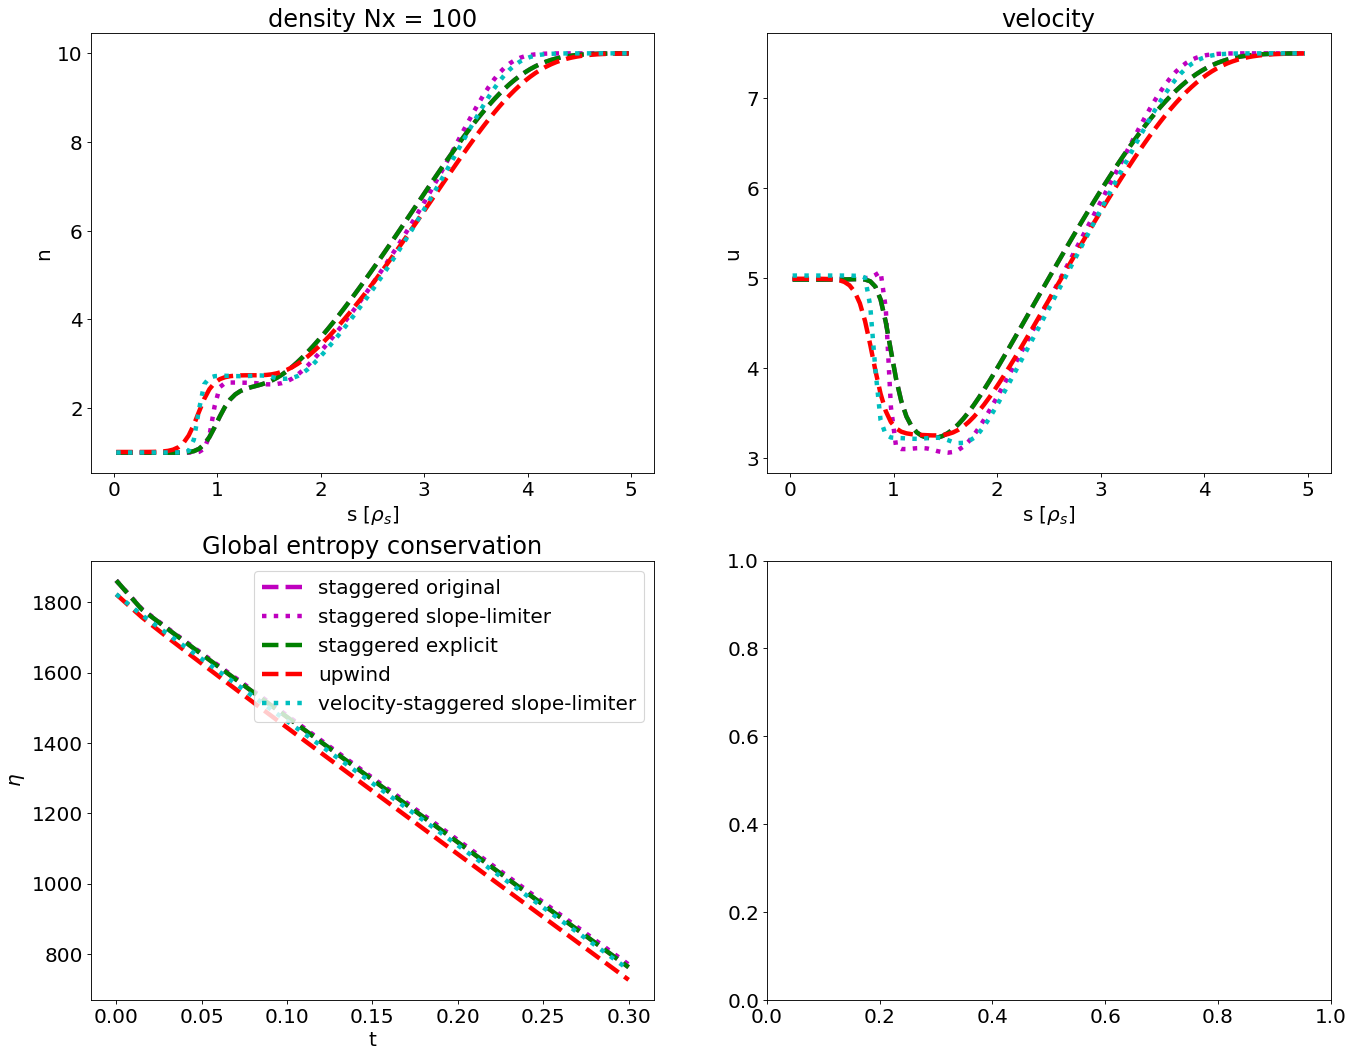

In [15]:
# Here, we try to reproduce the plot in Herbin that explicit schemes have a non-entropic solution
# (which we cannot)
p_list = []
for p in [
    {"type" : "staggered", "variant" : "original", "ls" : "m--"},
    {"type" : "staggered", "variant" : "slope-limiter", "ls": "m:"},
    {"type" : "staggered", "variant" : "explicit", "ls" : "g--"},
    {"type" : "upwind", "ls" : "r--"},
    {"type" : "velocity-staggered", "variant" : "slope-limiter", "ls" : "c:"},
         ] :
    params = make_navier_stokes_input()
    params["ls"] = p["ls"]
    params["grid"]["Nx"]= 100
    params["grid"] ["x"] = [0,5]
    params["init"] = {
        "type" : "riemann",
        "x_a" : 0.2,
        "n_l" : 1,
        "n_r" : 10,
        "u_l" : 5,
        "u_r" : 7.5
    }
    
    params["output"]["tend"] = 0.3
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
    params["physical"] ["alpha"] = 1
#     params["timestepper"]["type"] = "ERK"
#     params["timestepper"]["tableau"]  = "Euler"
    params["advection"] = p
    p_list.append(params)
plot_navier_stokes(p_list)

Now we initialize a plane wave in the density and zero velocity. We observe the formation of shocks. Due to Burger's term the wave crest travels faster than the valley. We investigate the addition of a small viscosity.
Since we do not have an analytical solution we treat a high resolution staggered scheme as the true solution:

staggered slope-limiter
	Function calls: 15053.0 Failed: 811.0
staggered original
	Function calls: 1982.0 Failed: 0.0
staggered slope-limiter
	Function calls: 3878.0 Failed: 0.0
velocity-staggered explicit
	Function calls: 2015.0 Failed: 0.0
velocity-staggered slope-limiter-explicit
	Function calls: 3779.0 Failed: 0.0
staggered-direct
	Function calls: 6080.0 Failed: 0.0
log-staggered explicit
	Function calls: 3113.0 Failed: 0.0


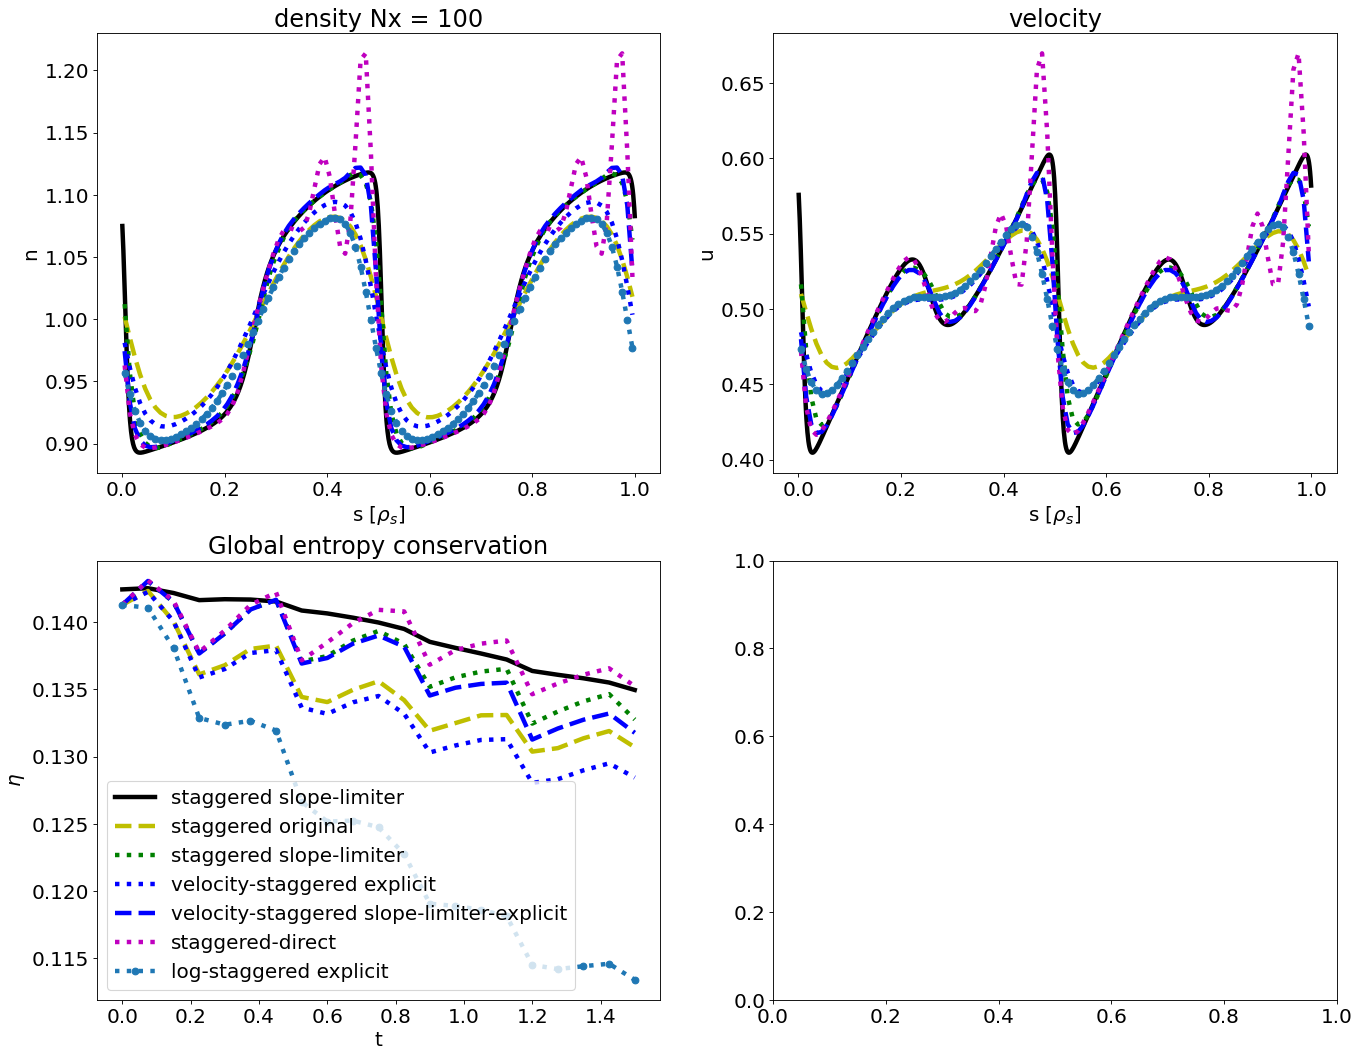

In [32]:
p_list = []
for p in [
    {"type" : "high_res", "ls" : "k-"},
    {"type" : "staggered", "variant" : "original", "ls" : "y--"},
    {"type" : "staggered", "variant" : "slope-limiter", "ls" : "g:"},
#     {"type" : "staggered", "variant" : "explicit", "ls" : "g--"},
#     {"type" : "staggered", "variant" : "slope-limiter-explicit", "ls" : "g:"},
#     {"type" : "velocity-staggered", "variant" : "original", "ls" : "b:"},
    {"type" : "velocity-staggered", "variant" : "explicit", "ls" : "b:"},
    {"type" : "velocity-staggered", "variant" : "slope-limiter-explicit", "ls" : "b--"},
#     {"type" : "velocity-staggered", "variant" : "slope-limiter", "ls" : "b--"},
#     {"type" : "centered", "ls" : "m:"},
    {"type" : "staggered-direct", "ls" : "m:"},
    {"type" : "log-staggered", "ls" : "o:", "variant" : "explicit"},
#     {"type" : "upwind", "ls" : "r--"},
#     {"type" : "upwind2", "ls" : "r:"},
         ] :
    params = make_navier_stokes_input()
    params["grid"]["Nx"]= 100
    params["ls"] = p["ls"]
    if( p["type"] == "high_res") :
        params["grid"]["Nx"] = 1000
        p["type"] = "staggered"
        p["variant"] = "slope-limiter"
    params["init"] = {
        # A sine wave in density with 0 velocity
        "type" : "wave",
        "n_0" : 1,
        "u_0" : 0.5,
        "A" : 0.2,
        "B" : 0.1,
        "k" : 4*np.pi,
    }
    params["bc"] = {"density" : "PER", "velocity" : "PER"}
    params["physical"]["nu_n"] = 0
    params["physical"]["nu_u"] = 1e-3
    params["output"]["tend"] = 1.5
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
    if( p["type"] == "upwind" or p["type"] == "upwind2" 
       or p["type"] == "centered" or p["type"] == "staggered-direct"
       or p["type"] == "log-staggered"):
        params["timestepper"]["type"] = "ERK"
        params["timestepper"]["tableau"]  = "Bogacki-Shampine-4-2-3"
    elif( p["variant"] == "explicit" or p["variant"] == "slope-limiter-explicit") :
        params["timestepper"]["type"] = "ERK"
        params["timestepper"]["tableau"]  = "Bogacki-Shampine-4-2-3"
    params["physical"] ["alpha"] = 1
    params["physical"] ["gamma"] = 1
#     params["timestepper"]["type"] = "ERK"
#     params["timestepper"]["tableau"]  = "Euler"
    params["advection"] = p
    p_list.append(params)
plot_navier_stokes(p_list)

We observe that
- shocks can form due to burgers term (the wave top moves faster than the wave bottom, steepening the front)
- surprisingly the collocated-upwind scheme is off by quite a bit for the low resolution ( but gets closer for higher resolution and higher viscosity)
- for very high resolution (Nx = 1000) all schemes coincide (not shown)
- if the viscosity is too small the centered scheme cannot compete (not shown in plot but it is far off)
- for the low resolution (Nx = 100) the velocity-staggered scheme seems qualitatively to behave as the staggered schemes, also in the entropy conservation, except for a slightly too large density
- surprisingly the explicit schemes need less function evaluations to achieve the solution. This is because even if the schemes need the same timestep the Bogacki-Shampine method has the fsal property and can thus save on function evaluations
- with the same ARK-4-2-3 tableau the explicit variants need slightly more timesteps than the implicit ones

In [28]:
# The mms method is to check that all terms are implemented correctly
# Maybe this should be presented in a nice table
p_list = []
for p in [
    {"type" : "staggered-direct"},
    {"type" : "staggered", "variant" : "original"},
    {"type" : "staggered", "variant" : "slope-limiter-explicit"},
    {"type" : "upwind"},
    {"type" : "velocity-staggered", "variant" : "slope-limiter-explicit"},
    {"type" : "log-staggered", "variant" : "slope-limiter"},
    {"type" : "upwind2"},
    {"type" : "centered"},
         ] :
    for Nx in [100,200,400,800,1600,3200]:
        params = make_navier_stokes_input()
        params["grid"]["Nx"]= Nx
        params["output"]["tend"] = 0.1
        params["init"] = {
             # Manufactured solution without shock
            "type" : "mms",
            "n_0" : 1,
            "u_0" : 0.5,
            "A" : 0.2,
            "B" : 0.1,
            "k" : 4*np.pi,
            "v" : 1
            # Analytical solution only for gamma : 1
        }
        params["bc"] = {"density":"PER", "velocity" : "PER"}
        params["physical"]["nu_u"] = 0.0
        params["physical"]["gamma"] = 1
        params["physical"]["alpha"] = 1
        params["timestepper"]["type"] = "ARK"
        params["timestepper"]["tableau"]  = "ARK-4-2-3"
        params["advection"] = p
        rep.clean()
        rep.run( params)
        ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
        var = ncin.variables
        last_idx  = var["time"].shape[0]-1
        error_n = var["density"][:,:] - var["density_ana"][:,:]
        norm_ana_n = np.linalg.norm( var["density_ana"][last_idx,:], ord=1)
        error_u = var["velocity"][:,:] - var["velocity_ana"][:,:]
        norm_ana_u = np.linalg.norm( var["velocity_ana"][last_idx,:], ord=1)
        #norm_ana = np.size( error[last_idx,:])
        l = f"{params['advection']['type']}"
        if( "variant" in params["advection"].keys() ):
            l = l + f" {params['advection']['variant']}"
        print( f"{l} {Nx} {np.linalg.norm(error_n[last_idx,:],ord=1)/norm_ana_n}\
\t{np.linalg.norm(error_u[last_idx,:], ord=1)/norm_ana_u}")
        ncin.close()

staggered-direct 100 0.00023883059730405505	0.0004248182126295709
staggered-direct 200 5.9750222282194396e-05	0.00010643184229219504
staggered-direct 400 1.4944777697089295e-05	2.66815011436608e-05
staggered-direct 800 3.761296793066693e-06	6.711837138167615e-06
staggered-direct 1600 1.2762232838314791e-06	1.9048567659263327e-06
staggered-direct 3200 5.622431185583685e-07	6.513277808619516e-07
staggered original 100 0.004072477614311855	0.00760827820683443
staggered original 200 0.0020872101265738486	0.0036963351868641494
staggered original 400 0.0010567156976690674	0.0018188921014749874
staggered original 800 0.000531758873986143	0.0009021892548198135
staggered original 1600 0.000266713864045338	0.0004492357264670533
staggered original 3200 0.00013356514964580647	0.00022415462694460431
staggered slope-limiter-explicit 100 0.0004412136384010058	0.0009857559174023824
staggered slope-limiter-explicit 200 0.00011217105913504389	0.00024358590540703328
staggered slope-limiter-explicit 400 2

In [16]:
%matplotlib notebook
params = make_navier_stokes_input()
params["grid"]["Nx"]= 1000
params["grid"]["x"] = [0,5]

params["output"]["tend"] = 0.5

params["advection"] = {"type" : "staggered"}
params["output"]["maxout"] = 200
params["init"] ["x_a"] = 2.5
# Run simulation
rep.clean()
rep.run( params, error="display", stdout="ignore")


fcols = 2
frows = 1
fig,ax=plt.subplots(frows,fcols,figsize=(fcols*10,frows*8),dpi= 80, facecolor='w', edgecolor='k')

ax[0].set_xlabel( "x")
ax[0].set_ylabel( "n")
ax[0].set_ylim(0,1.1)


ax[1].set_title( f"u(x,t)")
ax[1].set_xlabel( "x")
ax[1].set_ylabel( "u")
ax[1].set_ylim(0, 2.0)


ncin = Dataset( "temp.nc", 'r', format="NETCDF4")

x = ncin["x"][:]
time = ncin["time"][:]
ax[0].set_title( f"n(x,t) Nx = {params['grid']['Nx']} t = {time[0]:4.2f}")   


im0, = ax[0].plot( x, ncin["density"][0,:], lw=2)
im1, = ax[1].plot( x, ncin["velocity"][0,:], lw=2)

frames = params["output"]["maxout"]
def animate_fluid(iter):
    ax[0].set_title( f"n(x,t) Nx = {params['grid']['Nx']} t = {time[iter]:4.2f}") 
    im0.set_data (x, ncin["density"][iter,:])
    im1.set_data( x, ncin["velocity"][iter,:])
    return ax

ani = animation.FuncAnimation(fig,animate_fluid,frames=frames,interval=2,blit=True,repeat=True)
# plt.show()
writer = animation.writers['ffmpeg'](fps=50)

ani.save('breaking_dam_on_wet_bed.mp4',writer=writer,dpi=100)
ncin.close()

<IPython.core.display.Javascript object>

In [17]:
%matplotlib inline

### Plasma two-fluid equations

As a next step we investigate the two-fluid equations (also known as two-fluid Euler-Poisson system)
 \begin{align}
     \frac{\partial }{\partial t} n_e&= - \frac{\partial}{\partial x} (u_en_e )  + S_{n} \\
     \frac{\partial }{\partial t} n_i&= - \frac{\partial}{\partial x} (u_in_i )  + S_{n} \\   
    \frac{\partial }{\partial t} n_eu_e&= - \frac{\partial}{\partial x} n_eu_e^2 - \frac{\tau_e}{\mu_e}\frac{\partial}{\partial x} n_e - \frac{1}{\mu_e} n_e\frac{\partial}{\partial x} \phi - \frac{\eta}{\mu_e} n_i (n_i u_i - n_e u_e) + \nu_{u,e}\frac{\partial^2}{\partial x^2} u_e\\
     \frac{\partial }{\partial t} n_iu_i&= - \frac{\partial}{\partial x} n_iu_i^2 - \frac{\tau_i}{\mu_i}\frac{\partial}{\partial x} n_i - \frac{1}{\mu_i}n_i\frac{\partial}{\partial x} \phi - \frac{\eta}{\mu_i} n_i (n_i u_i - n_e u_e) + \nu_{u,i}\frac{\partial^2}{\partial x^2} u_i
 \end{align}
 which is closed by the one-dimensional Poisson equation
 \begin{align}
 -\frac{\partial^2}{\partial x^2} \phi = \frac{n_i - n_e}{\epsilon_D}
 \end{align}
 
 where we have Gyro-Bohm normalization and $\mu_e = -m_e/m_i$, $\mu_i = 1$, $\tau_e = -1$ and $\tau_i = T_i / T_e$. Further, 
 we have $\eta = 0.51 \nu_{ei,0}/ \Omega_{ce}$ and $\nu_{u,e} = 0.73
 \Omega_{ce} / \nu_{ei,0}$ and $\nu_{u,i} = 0.96 \Omega_{ci} / \nu_{ii,0}$. Last, we have the Debye parameter $\epsilon_D = \lambda_D^2 / \rho_s^2$ with the Debye length $\lambda_D$ and the
 ion gyro-radius at electron temperature $\rho_s$. Note that we choose the peculiar signs in $\mu_e$ and $\tau_e$ such that the electron and ion momentum equations have exactly the same form, which makes it easy to implement.
 
 Also note that we choose Bohm normalization based on gyro-radius $\rho_s$ and gyro-frequency $\Omega_{ci}$  because this is how we normalize the three-dimensional model. However, there is no magnetic field in the model and so the gyration does not appear. The more natural normalisation uses plasma frequency and Debye length, which makes the $\epsilon_D$ parameter disappear {cite}`Sack1987`. 
 
 The spatial domain is given by
$[-L_\parallel /2 ; L_\parallel/2]$, where $L_\parallel = 2\pi q R_0$ with $q=3$ and $R_0=0.545$m approximating the length of a fieldline from divertor to divertor in the Compass SOL. We use $N_x$ points.
 
 #### Neutral fluid limit
 We reach the limit of Navier Stokes fluid equations by first setting
 $\mu_e = 0$. Then we find from the electron momentum equation $-\tau_e \partial_x n_e - n_e\partial_x \phi - \eta n_e j = 0$, which
yields the force term $-\tau_i \partial_x n_i + \tau_e \partial_x n_i + \tau_e \epsilon_D \partial_x^3 \phi + \epsilon_D \partial_x (\partial_x \phi)^2 / 2 $ in the ion momentum equation. In the limit $\epsilon_D=0$ the
ion continuity and ion momentum equations thus decouple from the system and yield the Navier Stokes equations.

#### Adiabatic electrons
In the limit of $\mu_e=0$ and vanishing resistivity $\eta =0$
the electron force balance reduces to $\partial_x n_e = n_e \partial_x\phi$ which is solved by $n_e = n_{e,0}\exp(\phi)$. 
 \begin{align}
     \frac{\partial }{\partial t} n_i&= - \frac{\partial}{\partial x} (u_in_i ) + S_{n} \\   
     \frac{\partial }{\partial t} n_iu_i&= - \frac{\partial}{\partial x} n_iu_i^2 - \tau_i\frac{\partial}{\partial x} n_i - n_i\frac{\partial}{\partial x} \phi + \nu_{u,i}\frac{\partial^2}{\partial x^2} u_i
 \end{align}
 which is closed by the one-dimensional non-linear Poisson   equation (choosing $n_{e,0}=1$)
 \begin{align}
 -\frac{\partial^2}{\partial x^2} \phi = \frac{n_i - \exp(\phi)}{\epsilon_D}
 \end{align}

In [45]:
# feltorutilities is still a private repository under development
# Ask Matthias mattwi@fysik.dtu.dk to get access!
import feltorutilities as fp
# These parameters are for a Tokamak
show = ["name", "mu", "R_0", "resistivity", "tau", 
        "epsilon_D", "viscosity_e", "viscosity_i"]
physical={"name" : "Compass",
    "beta" : 1e-4, "resistivity": 1e-4, #change both to change n_0
    "tau" : 1,
    "m_i" : fp.deuteron_mass, "R_0" : 545, "R": 0.545,
    "a": 0.175, "q":2, "scaleR" : 1.45, "Nz" : 32}
fp.numerical2physical( physical, physical)
table = dict()
for s in show :
    table[s] = fp.parameters2quantity( physical, s)

table["lx"] = 2*np.pi*table["R_0"]*3
for s in [*show, "lx"]:
    print( s, "\t\t", table[s])
print( table["viscosity_i"]/ (2*np.pi*3*table["R_0"])**2  )

Invert for given R
name 		 Compass
mu 		 -0.00027244371074816386
R_0 		 545
resistivity 		 0.0001
tau 		 1
epsilon_D 		 4.1458919332419e-05
viscosity_e 		 3700.000000592561
viscosity_i 		 113.89049597255578
lx 		 10273.007977238623
1.0791758884448799e-06


In [46]:
# The code plasma.cpp discretizes the above equations
# in space and time with various schemes.
# In the following we document the possible input parameters:
def make_plasma_input(physical) :
    # PARAM: physical: dict with entries: "lx", "mu", "epsilon_D",
    # "viscosity_e", "viscosity_i", "resistivity", "tau"
    return {
    "grid" : {
        "Nx" : 32,
        # number of grid points
        "x" : [-table["lx"]/2, table["lx"]/2],
        # spatial domain [x_0,x_1]
    },
#     "init":
#     {
#         # A sine wave in density with 0 velocity
#         "type" : "wave",
#         "amp" : 0.5,
#         "n_0" : 1,
#         "k" : 4*np.pi,
#         "x_0" : 0
#     },
#     "init":
#     {
#         "type" : "step", # a step in density, 0 velocity
#         "x_a" : 0.5, # location of jump
#         "n_l" : 1,   # density left of jump
#         "n_r" : 0.2, # density right of jump
#     },
    "init":
    {
        "type" : "soft-step",
        "x_a" : 0., # location of jump (in units of lx)
        "alpha" : 0.1, # transition width (in units of lx)
        # [x_a - alpha/2, x_a+alpha/2]
        "n_l" : 1,   # density left of jump
        "n_r" : 0.2, # density right of jump
    },
#     "init":
#     {
#          # Manufactured solution without shock
#         "type" : "mms",
#         "n_0" : 1,
#         "u_0" : 0.5,
#         "A" : 0.2,
#         "B" : 0.1,
#         "k" : 4*np.pi,
#         "v" : 1
#     },
    "advection" : 
    {
        "type" : "staggered", 
        # centered
        # staggered (allows variant)
        "variant" : "original"
        # original (The original scheme, 1st order)
        # explicit (Take force terms explicitly)
        # slope-limiter (Use 2nd order flux)
        # slope-limiter-explicit (Use 2nd order flux
        #     and force terms explicit)
    },
    "timestepper":
    {
        # The Additive Runge Kutta (ARK) method is a semi-implicit
        # embedded Runge Kutta scheme that works for all (explicit
        # and implicit) advection schemes above
        "type" : "ARK",
        "tableau" : "ARK-4-2-3",
        "rtol" : 1e-6, # relative tolerance
        "atol" : 1e-7  # absolute tolerance
        # The Embedded Runge Kutta (ERK) only works 
        # for explicit schemes
        # "type" : "ERK", 
        # "tableau" : "Bogacki-Shampine-4-2-3"
    },
    "physical":
    {
        "type" : "original", # plasma two-fluid equations
#         "type" : "adiabatic", # adiabatic electrons 
        # n_e and u_e are 0 in output file
        "nu_u" : [table["viscosity_e"], table["viscosity_i"]],
        # viscosity for [electrons, ions]
        "nu_n" : [0.0, 0.0], 
        # diffusivity for [electron, ions]
        # (can be used to stabilize)
        "resistivity" : table["resistivity"],
        # plasma resistivity eta
        "mu" : table["mu"],
        # negative electron to ion mass ratio
        "tau" : table["tau"],
        # ion to electron temperature ratio
        "epsilon_D" : table["epsilon_D"]
    },
    "bc" :
    {
         # one of PER, NEU, DIR, DIR_NEU, NEU_DIR
        "density": "NEU",
        "velocity" : "NEU",
        "potential" : "DIR_NEU"
    },
    "poisson":
    {
#         "type" : "anderson", # most general non-linear solver
        "type" : "gmres",
#         "type" : "cg", # if it works it is the fastest method
#         "type" :"bicgstab",
#         # parameters for iterative solvers
        "max_inner" : 30, # 30 is a good number
        "max_outer" : 3, # 3-10
        "l_input" : 3, # 2-4 is a good number
        "mMax" : 10, # 3 - 10 is a good number
        "damping" : 1e-2, # 0.1 to 1e-3 is a good start
        
        "eps" : 1e-6, # accuracy          
    },
    "output":
    {
        # The simulation will run from t = 0 to t = t_end
        "tend" : 0.001, # end time
        # Choose a number of (equidistant in time) outputs
        # in output file (excluding first)
        "maxout" : 20 
    }
    }

In [71]:
# This works completely analogous to the continuity case above
rep = simplesim.Repeater("./plasma","temp.json", "temp.nc")
rep.clean()
rep.run( make_plasma_input(table), error="display", stdout="ignore")
ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
print( "FILE CONTENTS")
for v in ncin.variables:
    if v == "time" : 
        print(f"{v} {ncin.variables[v].shape}")
    else : 
        print( f"{v} {ncin.variables[v].shape}",
            f"\t{ ncin.variables[v].long_name}")

ncin.close()

FILE CONTENTS
time (21,)
x (32,) 	x-coordinate in Computational coordinate system
failed (21,) 	Accumulated Number of failed steps
duration (21,) 	Computation time for the latest output
nsteps (21,) 	Accumulated Number of calls to the timestepper (including failed steps)
electrons (21, 32) 	Numerical electron density
ions (21, 32) 	Numerical electron density
ue (21, 32) 	Numerical electron velocity
ui (21, 32) 	Numerical ion velocity
potential (21, 32) 	potential
electrons_ana (21, 32) 	Analytical solution to the electron density
ions_ana (21, 32) 	Analytical solution to the ion density
ue_ana (21, 32) 	Analytical solution to the electron velocity
ui_ana (21, 32) 	Analytical solution to the ion velocity
potential_ana (21, 32) 	Analytical solution to the potential


In [48]:
# Again, we define a plotting routine that loops over
# parameters sets, runs simulations and plots the results
def plot_plasma( p_list):
    
    plt.rcParams.update({'font.size': 20})
    frows = 3
    fcols = 2

    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*10,frows*8),dpi= 80, facecolor='w', edgecolor='k')
    #https://matplotlib.org/stable/tutorials/colors/colormaps.html

    plotted = False
    for p in p_list :
        rep.clean()
        rep.run( p, error="display", stdout="ignore")
        ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
        var = ncin.variables
        time = var["time"][:]
        last_idx  = time.shape[0]-1
        nsteps = var["nsteps"][last_idx]
        failed = var["failed"][last_idx]
        error = var["electrons"][:,:] - var["electrons_ana"][:,:]
        norm_ana = np.linalg.norm( var["electrons_ana"][last_idx,:], ord=1)
        #norm_ana = np.size( error[last_idx,:])


        x = var["x"][:]

        if not plotted and not norm_ana == 0:
            im = ax[0][0].plot(x, var["electrons_ana"][last_idx,:],
                            color='k', label="analytical", lw=4)
            im = ax[0][1].plot(x, var["ions_ana"][last_idx,:],
                            color='k', label="analytical", lw=4)
            plotted = True
        l = f"{p['advection']['type']}"
        if( "variant" in p["advection"].keys() ):
            l = l + f" {p['advection']['variant']}"
        
        print(l)
        if not norm_ana == 0:
            print( f"L2 Error norm is {np.linalg.norm(error[last_idx,:], ord=1)/norm_ana:.2e}",end=" ")
        print( f"Function Calls is {nsteps} Failed {failed}")
        electrons = var["electrons"][last_idx,:]
        if p["physical"]["type"] == "adiabatic" :
            electrons = np.exp( var["potential"][last_idx ,:])
        im = ax[0][0].plot(x,electrons, label=l, lw=4)
        im = ax[0][1].plot(x,var["ions"][last_idx,:]-electrons, label=l, lw=4)
        im = ax[1][0].plot( x, var["ue"][last_idx,:], lw=4)
        im = ax[1][1].plot( x, var["ui"][last_idx,:], lw=4)
        potential = var["potential"][last_idx,:]
        im = ax[2][0].plot( x, potential, lw=4)
        electric = -np.gradient( potential, x)
        im = ax[2][1].plot( x, electric, lw=4)
        ncin.close()
    ax[0][0].set_title( f"electron density Nx = {p['grid']['Nx']} t = {time[last_idx]:8.4f}")
    ax[0][0].set_xlabel( r"s [$\rho_s$]")
    ax[0][0].set_ylabel("n")
    ax[0][0].legend()
    
    ax[0][1].set_title( f"charge density")
    ax[0][1].set_xlabel( r"s [$\rho_s$]")
    ax[0][1].set_ylabel("u")
    
    ax[1][0].set_title( f"electron velocity")
    ax[1][0].set_xlabel( r"s [$\rho_s$]")
    ax[1][0].set_ylabel( r"$u_e$")

    ax[1][1].set_title( f"ion velocity")
    ax[1][1].set_xlabel( r"s [$\rho_s$]")
    ax[1][1].set_ylabel( r"$u_i$")   
    
    ax[2][0].set_title( f"potential")
    ax[2][0].set_xlabel( r"s [$\rho_s$]")
    ax[2][0].set_ylabel( r"$\phi$")
    
    ax[2][1].set_title( f"electric field")
    ax[2][1].set_xlabel( r"s [$\rho_s$]")
    ax[2][1].set_ylabel( r"$E$")   
    

First, we simulate the full plasma two-fluid system.

staggered original
Function Calls is 262.0 Failed 0.0
staggered slope-limiter
Function Calls is 262.0 Failed 0.0
staggered explicit
Function Calls is 262.0 Failed 0.0
staggered slope-limiter-explicit
Function Calls is 262.0 Failed 0.0


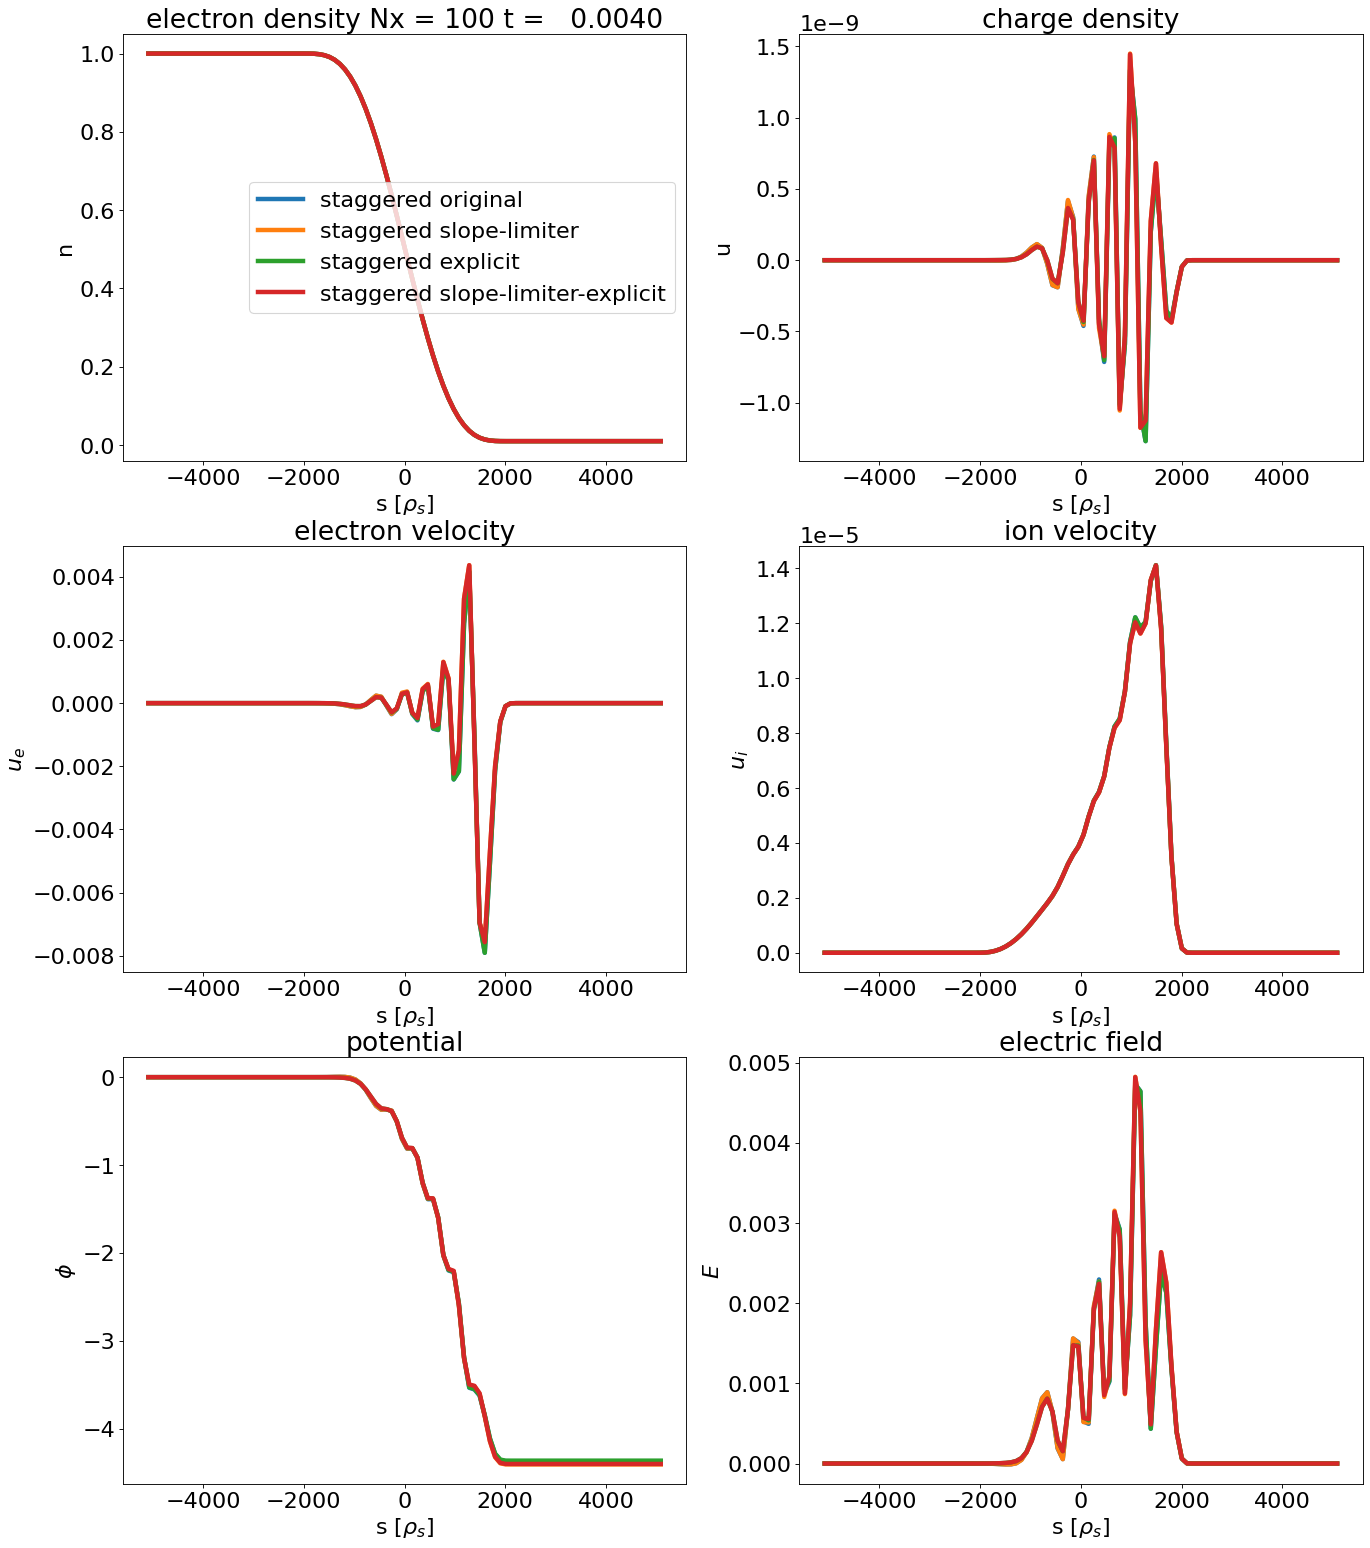

In [50]:
p_list = []
for p in [
    {"type" : "staggered", "variant" : "original"},
    {"type" : "staggered", "variant" : "slope-limiter"},
    {"type" : "staggered", "variant" : "explicit"},
    {"type" : "staggered", "variant" : "slope-limiter-explicit"},
#     {"type" : "centered"},
         ] :
    params = make_plasma_input(table)
    params["init"]["alpha"] = 0.4
    params["init"]["n_r"] = 0.01
    params["grid"]["Nx"]= 100
    params["output"]["tend"] =4e-3 #1e-4 to 1e-2
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
    params["poisson"]["eps"]= 1e-12
    params["poisson"]["type"] = "bicgstab"
    #params["physical"]["mu"] = -1
#     params["physical"]["nu_u"] = [0.,0.]
    params["physical"]["tau"] = 0.
    params["physical"]["type"] = "original"
    params["advection"] = p
    params["timestepper"]["rtol"] = 1e-5
    
    p_list.append(params)
plot_plasma(p_list)

We observe
- steps in the potential
- oscillations in the electron velocity and electric field indicating rapid plasma oscillations

staggered slope-limiter
Function Calls is 8616.0 Failed 782.0
staggered slope-limiter-explicit
Function Calls is 8759.0 Failed 821.0


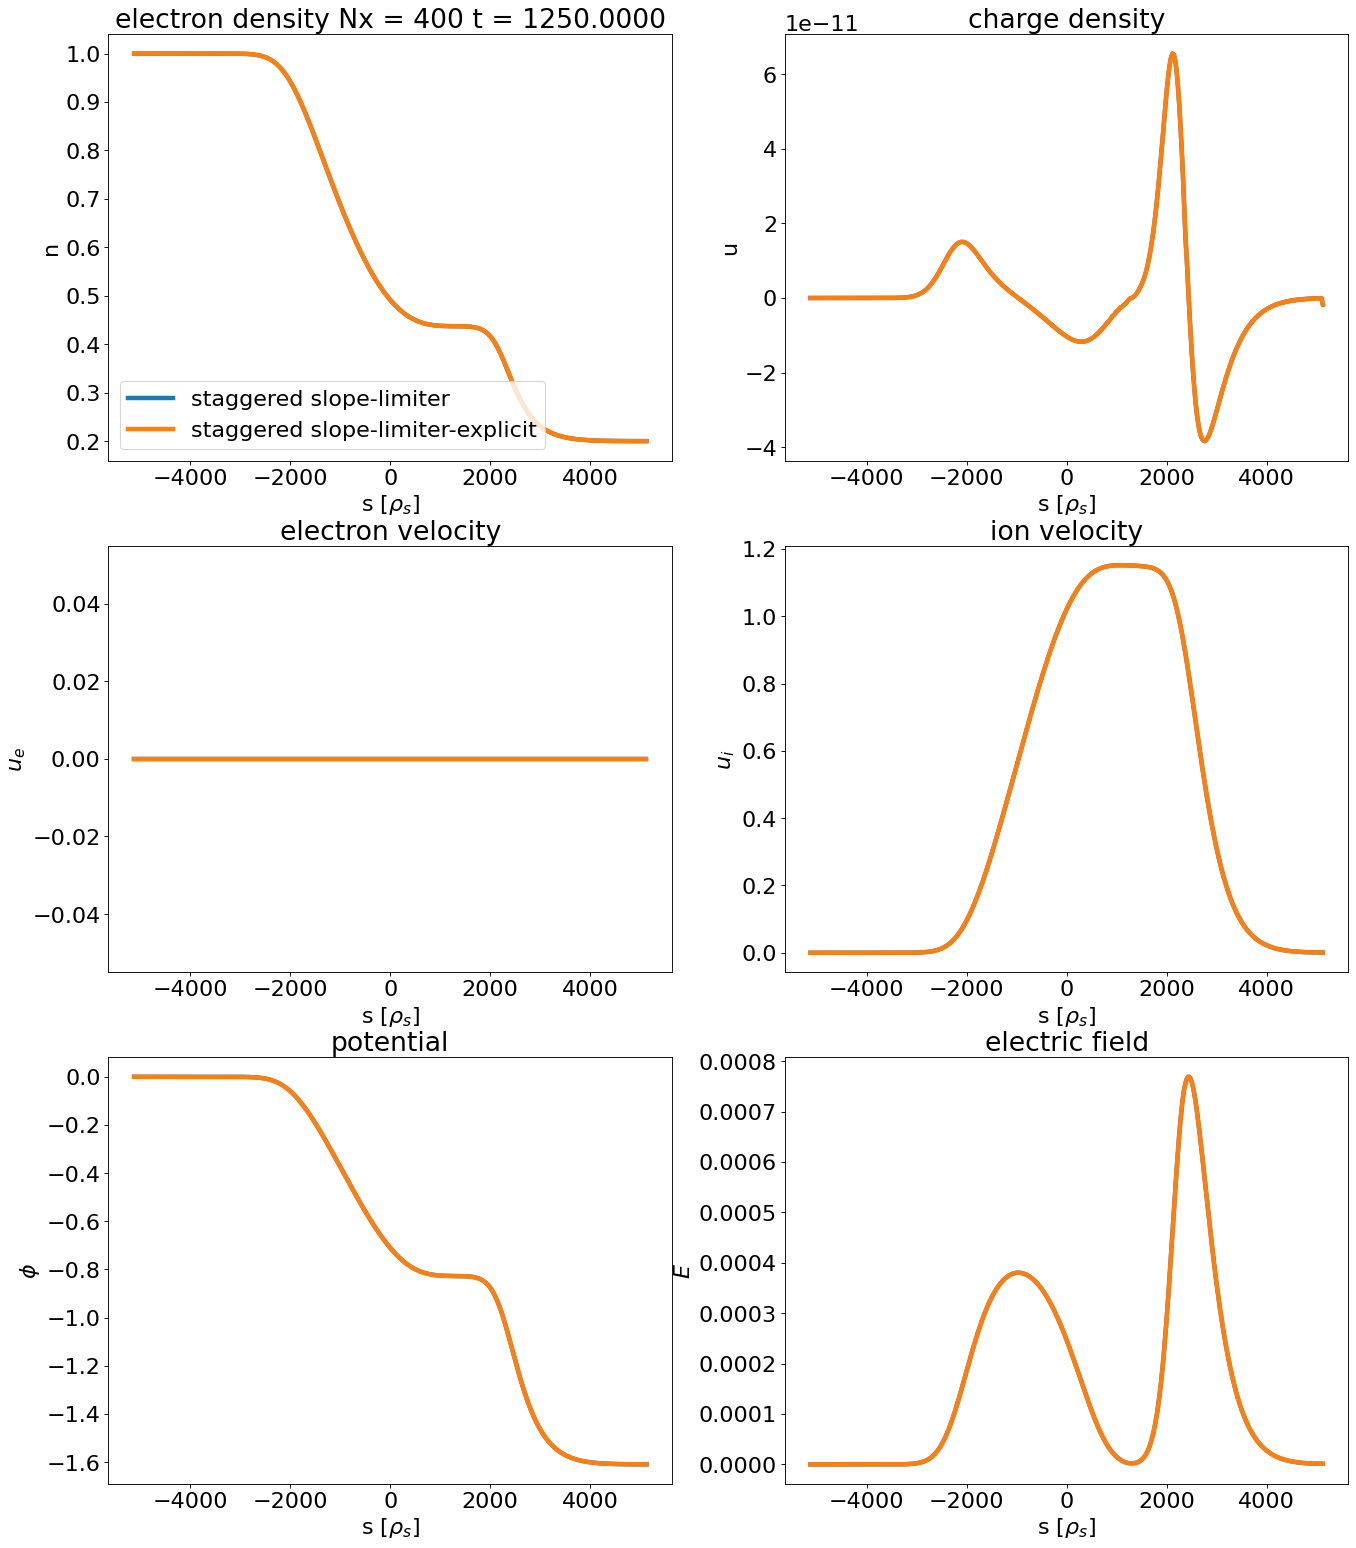

In [72]:
# Let us try adiabatic electrons
p_list = []
for p in [
#     {"type" : "staggered", "variant" : "original"},
    {"type" : "staggered", "variant" : "slope-limiter"},
#     {"type" : "staggered", "variant" : "explicit"},
    {"type" : "staggered", "variant" : "slope-limiter-explicit"},
#     {"type" : "centered"},
         ] :
    params = make_plasma_input(table)
    params["init"]["x_a"] = -0.0
    params["init"]["alpha"] = 0.001
    params["init"]["n_r"] = 0.2
    params["grid"]["Nx"]= 400
    params["output"]["tend"] =1.25e3#1e-4 to 1e-2
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
    params["poisson"]["eps"]= 1e-12
    params["poisson"]["type"] = "anderson"
    params["poisson"]["damping"] = 1e-1
    #params["physical"]["mu"] = -1
#     params["physical"]["nu_u"] = [0.,0.]
    params["physical"]["tau"] =1.
    params["physical"]["type"] = "adiabatic"
    params["physical"]["resistivity"] = 0.0

    params["advection"] = p
    params["timestepper"]["rtol"] = 1e-5
    
    p_list.append(params)
plot_plasma(p_list)

In [24]:
# The mms method is to check that all terms are implemented correctly
p_list = []
for p in [
    {"type" : "staggered", "variant" : "original"},
    {"type" : "staggered", "variant" : "slope-limiter"},
    {"type" : "staggered", "variant" : "slope-limiter-explicit"},
    {"type" : "centered"},
         ] :
    for Nx in [100,200,400]:#,800,1600,3200]:
        params = make_plasma_input(table)
        params["grid"]["Nx"]= Nx
        params["grid"]["x"] = [0.0,1.0]
        params["output"]["tend"] = 1e-3
        params["init"] = {
             # Manufactured solution without shock
            "type" : "mms",
            "n_0" : 1.0,
            "u_0" : 0.5,
            "A" : 0.2,
            "B" : 0.1,
            "k" : 4*np.pi,
            "v" : 1.0
        }
        params["bc"] = {"density":"PER", "velocity" : "PER",
                        "potential" : "PER"}
        params["physical"]["nu_u"] = [0.0,0.0]
        params["timestepper"]["type"] = "ARK"
        params["timestepper"]["tableau"]  = "ARK-4-2-3"
        params["poisson"]["eps"] = 1e-8
        params["timestepper"]["rtol"] = 1e-7
        params["advection"] = p
        rep.clean()
        rep.run( params)
        ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
        var = ncin.variables
        last_idx  = var["time"].shape[0]-1
        
        error = var["electrons"][:,:] - var["electrons_ana"][:,:]
        norm_ana = np.linalg.norm( var["electrons_ana"][last_idx,:], ord=2)
        error_ne = np.linalg.norm(error[last_idx,:],ord=2)/norm_ana
        
        error = var["ue"][:,:] - var["ue_ana"][:,:]
        norm_ana = np.linalg.norm( var["ue_ana"][last_idx,:], ord=2)
        error_ue = np.linalg.norm(error[last_idx,:], ord=2)/norm_ana
        
        error = var["potential"][:,:] - var["potential_ana"][:,:]
        norm_ana = np.linalg.norm( var["potential_ana"][last_idx,:], ord=2)
        error_phi = np.linalg.norm(error[last_idx,:], ord=2)/norm_ana
        #norm_ana = np.size( error[last_idx,:])
        l = f"{params['advection']['type']}"
        if( "variant" in params["advection"].keys() ):
            l = l + f" {params['advection']['variant']}"
        print( f"{l} {Nx} {error_ne}\t{error_ue}\t{error_phi}")
        ncin.close()

staggered original 100 5.580296254580168e-05	0.023195936061266877	0.002575918155506441
staggered original 200 2.8282088300430025e-05	0.011705288819374821	0.0011112195383459545
staggered original 400 1.4233827548520823e-05	0.005877695490863391	0.0005277675970782922
staggered slope-limiter 100 1.090675926467633e-05	0.001976291856643779	0.001339650743226408
staggered slope-limiter 200 2.727761445330482e-06	0.0004996362259588693	0.00033494442001343896
staggered slope-limiter 400 6.808894613093873e-07	0.0001251456288766868	8.376258715632446e-05
staggered slope-limiter-explicit 100 1.0905408903246603e-05	0.001972221786447545	0.0013370735038095336
staggered slope-limiter-explicit 200 2.7259884698560088e-06	0.0004987128193436745	0.00033426421736756337
staggered slope-limiter-explicit 400 6.782599516324007e-07	0.00012512265402499096	8.355670477792765e-05
centered 100 2.8162603120836513e-06	0.002525936373990322	0.006341152712926746
centered 200 7.068546265656482e-07	0.0006277146840703361	0.00158

In [25]:
%matplotlib notebook
params = make_plasma_input(table)

params["init"]["alpha"] = 0.4
params["init"]["n_r"] = 0.01
params["grid"]["Nx"]= 500
params["timestepper"]["type"] = "ARK"
params["timestepper"]["tableau"]  = "ARK-4-2-3"
params["timestepper"]["rtol"] = 1e-6

params["poisson"]["eps"]= 1e-8
params["poisson"]["type"] = "bicgstab"
#params["physical"]["nu_u"] = [0.,0.]
params["physical"]["tau"] = 0.
params["physical"]["type"] = "original"

params["advection"] = {"type" : "staggered"}

params["output"]["tend"] =1e-1
params["output"]["maxout"] = 200
# Run simulation
rep.clean()
rep.run( params, error="display", stdout="ignore")
ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
var = ncin.variables

frows = 2
fcols = 3

fig,ax=plt.subplots(frows,fcols,figsize=(fcols*10,frows*8),dpi= 80, facecolor='w', edgecolor='k')
         

ax[0][0].set_xlabel( r"s [$\rho_s$]")
ax[0][0].set_ylabel("n")
ax[0][0].set_ylim(0,1.1)

ax[1][0].set_title( f"charge density")
ax[1][0].set_xlabel( r"s [$\rho_s$]")
ax[1][0].set_ylabel("u")
ax[1][0].set_ylim(-4e-9, 4e-9)

ax[0][1].set_title( f"electron velocity")
ax[0][1].set_xlabel( r"s [$\rho_s$]")
ax[0][1].set_ylabel( r"$u_e$")
ax[0][1].set_ylim(-2e-3, 2e-3)

ax[1][1].set_title( f"ion velocity")
ax[1][1].set_xlabel( r"s [$\rho_s$]")
ax[1][1].set_ylabel( r"$u_i$")   
ax[1][1].set_ylim(0, 3e-4)

ax[0][2].set_title( f"potential")
ax[0][2].set_xlabel( r"s [$\rho_s$]")
ax[0][2].set_ylabel( r"$E$")
ax[0][2].set_ylim(-5, 0)

ax[1][2].set_title( f"electric field")
ax[1][2].set_xlabel( r"s [$\rho_s$]")
ax[1][2].set_ylabel( r"$E$") 
ax[1][2].set_ylim(0, 6e-3)  


x = var["x"][:]
time = ncin["time"][:]
ax[0][0].set_title( f"electron density Nx = {params['grid']['Nx']} t = {time[0]:5.3f}")   
im0, = ax[0][0].plot( x, var["electrons"][0,:], lw=4)
im1, = ax[1][0].plot( x, var["ions"][0,:]-var["electrons"][last_idx,:], lw=4)
im2, = ax[0][1].plot( x, var["ue"][0,:], lw=4)
im3, = ax[1][1].plot( x, var["ui"][0,:], lw=4)
potential = var["potential"][0,:]
im4, = ax[0][2].plot( x, potential, lw=4)
electric = -np.gradient(potential, x)
im5, = ax[1][2].plot( x, electric, lw=4)
# ax[0][0].legend()

frames = params["output"]["maxout"]
def animate_expansion(iter):
    ax[0][0].set_title( f"electron density Nx = {params['grid']['Nx']} t = {time[iter]:5.3f}")
    im0.set_data (x, var["electrons"][iter,:])
    im1.set_data( x, var["ions"][iter,:]-var["electrons"][iter,:])
    im2.set_data( x, var["ue"][iter,:])
    im3.set_data( x, var["ui"][iter,:])
    potential = var["potential"][iter,:]
    im4.set_data( x, potential)
    electric = -np.gradient(potential, x)
    im5.set_data( x, electric)
    return ax

ani = animation.FuncAnimation(fig,animate_expansion,frames=frames,interval=2,blit=True,repeat=True)
# plt.show()
writer = animation.writers['ffmpeg'](fps=50)

ani.save('plasma_expansion.mp4',writer=writer,dpi=100)
ncin.close()

<IPython.core.display.Javascript object>

In [26]:
%matplotlib notebook

params = make_plasma_input(table)
params["init"]["x_a"] = -0.0
params["init"]["alpha"] = 0.001
params["init"]["n_r"] = 0.2
params["grid"]["Nx"]= 400
params["timestepper"]["type"] = "ARK"
params["timestepper"]["tableau"]  = "ARK-4-2-3"
params["timestepper"]["rtol"] = 1e-5
params["poisson"]["eps"]= 1e-12
params["poisson"]["type"] = "anderson"
#params["physical"]["nu_u"] = [0.,0.]
params["physical"]["tau"] =1.
params["physical"]["type"] = "adiabatic"
params["physical"]["resistivity"] = 0.0


params["advection"] = {"type" : "staggered"}
params["output"]["tend"] =1.25e3
params["output"]["maxout"] = 200
# Run simulation
rep.clean()
rep.run( params, error="display", stdout="ignore")
ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
var = ncin.variables

frows = 2
fcols = 3

fig,ax=plt.subplots(frows,fcols,figsize=(fcols*10,frows*8),dpi= 80, facecolor='w', edgecolor='k')
         

ax[0][0].set_xlabel( r"s [$\rho_s$]")
ax[0][0].set_ylabel("n")

ax[0][0].set_ylim(0, 1.1)
# ax[0][0].legend()

ax[1][0].set_title( f"charge density")
ax[1][0].set_xlabel( r"s [$\rho_s$]")
ax[1][0].set_ylabel("u")
ax[1][0].set_ylim(-6e-11, 6e-11)

ax[0][1].set_title( f"electron velocity")
ax[0][1].set_xlabel( r"s [$\rho_s$]")
ax[0][1].set_ylabel( r"$u_e$")
ax[0][1].set_ylim(-2e-2, 2e-2)

ax[1][1].set_title( f"ion velocity")
ax[1][1].set_xlabel( r"s [$\rho_s$]")
ax[1][1].set_ylabel( r"$u_i$")   
ax[1][1].set_ylim(0, 1.2)

ax[0][2].set_title( f"potential")
ax[0][2].set_xlabel( r"s [$\rho_s$]")
ax[0][2].set_ylabel( r"$E$")
ax[0][2].set_ylim(-1.6, 0)

ax[1][2].set_title( f"electric field")
ax[1][2].set_xlabel( r"s [$\rho_s$]")
ax[1][2].set_ylabel( r"$E$") 
ax[1][2].set_ylim(0, 1e-3)  


x = var["x"][:]
time = ncin["time"][:]
ax[0][0].set_title( f"electron density Nx = {params['grid']['Nx']} t = {time[0]:5.1f}")   

electrons = np.exp( var["potential"][0 ,:])
im0, = ax[0][0].plot( x, electrons, lw=4)
im1, = ax[1][0].plot( x, var["ions"][0,:]-electrons, lw=4)
im2, = ax[0][1].plot( x, var["ue"][0,:], lw=4)
im3, = ax[1][1].plot( x, var["ui"][0,:], lw=4)
potential = var["potential"][0,:]
im4, = ax[0][2].plot( x, potential, lw=4)
electric = -np.gradient(potential, x)
im5, = ax[1][2].plot( x, electric, lw=4)

frames = params["output"]["maxout"]
def animate_adiabatic(iter):
    ax[0][0].set_title( f"electron density Nx = {params['grid']['Nx']} t = {time[iter]:5.1f}")
    electrons = np.exp( var["potential"][iter ,:])
    im0.set_data (x, electrons)
    im1.set_data( x, var["ions"][iter,:]-electrons)
    im2.set_data( x, var["ue"][iter,:])
    im3.set_data( x, var["ui"][iter,:])
    potential = var["potential"][iter,:]
    im4.set_data( x, potential)
    electric = -np.gradient(potential, x)
    im5.set_data( x, electric)
    return ax

ani = animation.FuncAnimation(fig,animate_adiabatic,frames=frames,interval=2,blit=True,repeat=True)
# plt.show()
writer = animation.writers['ffmpeg'](fps=50)

ani.save('adiabatic_plasma_expansion.mp4',writer=writer,dpi=100)
ncin.close()

<IPython.core.display.Javascript object>

In [27]:
%matplotlib inline